# Source Localization using Distributed Sensors (Focus on one Sensor)
 **(Final version will read directly from Pyserial and data will be collected at higher sampling rate)**

The first thing I need is a position matrix for all the sensors. The reason to start from a position matrix and not a distance matrix is because this algorithm can be adapted to a scenario where the sensors are not in a static position. I will record those positions in a dictionary using as relative position the position of sensor 1.

In [66]:
%%html
<img src="sensors.jpg" alt="Drawing" style="width: 500px;" align= "middle">

In [67]:
import numpy as np
import scipy
from matplotlib import pyplot
from scipy import signal
from scipy.stats import norm
from collections import deque
import random
import scipy.sparse.linalg as splinalg

In [68]:
def R_dictionary(sensor, Hash):
    Hash.update(sensor)

#Growing my Position dictionary:
Hash={}
k=0
for j in np.array([0, 15, 30, 45]):
    for i in np.array([0, 10, 20]):
        k=k+1
        R_dictionary({k: [j, i]}, Hash)
print(Hash)

{1: [0, 0], 2: [0, 10], 3: [0, 20], 4: [15, 0], 5: [15, 10], 6: [15, 20], 7: [30, 0], 8: [30, 10], 9: [30, 20], 10: [45, 0], 11: [45, 10], 12: [45, 20]}


Now, I want to create a relative distance matrix by computing the Euclidean distance between each sensor. 

In [69]:
Rel_Pos= np.zeros((len(Hash), len(Hash)))
for i in  np.arange(len(Hash)):
    for j in np.arange(len(Hash)):
        Rel_Pos[i][j]= ((Hash[i+1][0] - Hash[j+1][0])**2 + (Hash[i+1][1] - Hash[j+1][1])**2)**(1./2.)
#pyplot.spy(Rel_Pos)
#pyplot.show()

TO DO:
* ~~Import the data and parse it~~
* ~~Make a routine that decomposes the signal at level 1: s= a1+d1~~
* ~~Use d1 to determine if there is an event if there is no event, don't do anything. If there is an event, fire the algorithm and record the time in which the event happened (t!)~~
* ~~With the data identify the ones that got highest frequency at t!~~
* ~~Assign probabilities to each sensor~~ ~~Breed~~
* ~~Do the triangulization method~~
* Do the things suggested by Jed in the gitter
    * ~~What does order of accuracy mean in this context?~~
    * ~~How would equations be if the medium is not isotropic so time delay is not just linear distance?~~
    * Eikonal Equation

**Triangularization** 

A common way to localize sources is using a method called the Triangularization Method. This means that one sensor communicates to two other sensors in order to localize where the source of the wave came from. The main Equation to be solved here takes the following form:

\begin{equation}
E(x_0, y_0)= 2(x_0^2+y_0^2-x_0x_2-x_0x_3-y_0y_2-y_0y_3) + x_2^2+x_3^2+y_2^2+y_3^2 - (r_{21}^2+r_{31}^2)(x_0^2+y_0^2-2(x_0x_1+y_0y_1)+x_1^2+y_1^2))^2
\end{equation}

In [87]:
def Event(sensor, right):
    ##############################################################################################################
    # MODULE FOR ANOMALY DETECTION
    # At the moment, I will be using a Discrete Wavelet Transform for this module using the Fast Wavelet Transform
    # Algorithm to detect events. I only care about the level 1 decomposition's second coefficient (d1) in  s= a1+d1
    # to identify whether there is an event or not. As the project develops, this module will detect events using
    # artificial intelligence
    ##############################################################################################################
    widths = np.arange(1, 31)
    sensor= np.array(sensor)
    cwtmatr = signal.cwt(sensor.astype(int), signal.ricker, widths)
    yesno=0
    left=right
    right = np.linalg.norm(cwtmatr[:, -1], np.inf)
    
    if right-left > 300:
        yesno = 1 
        sensdata= sensor[-1]   
    else:
        yesno = 0
        sensdata = np.zeros_like(right)
        
    return yesno, right, sensdata 

# TRIANGULARIZATION EXPRESSION
def F(x1, x2, x3, y1, y2, y3, r_21, r_31, u):
    x0= u[0]
    y0= u[1]
    return np.array([2*(x0**2 + y0**2 - x0*x2 -x0*x3 -y0*y2 -y0*y3)+ x2**2+ x3**2, 
                 y2**2 + y3**2 -(r_21**2+r_31**2)*(x0**2+y0**2-2*(x0*x1+y0*y1)
                                                + x1**2 + y1**2)])
# JACOBIAN OF THE TRIANGULARIZATION EXPRESSION
def J(x1, x2, x3, y1, y2, y3,  r_21, r_31, u):
    x0= u[0]
    y0= u[1]
    return np.array([[2*(2*x0-x2-x3), 2*(2*y0-y2-y3)], 
                    [-(r_21**2+r_31**2)*(2*x0-2*x1), -(r_21**2+r_31**2)*(2*y0-2*y1)]])

def F1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u):
    x0= u[0]
    y0= u[1]
    d1= ((x1-x0)**2+(y1-y0)**2)**(1/2)
    d2= ((x2-x0)**2+(y2-y0)**2)**(1/2)
    d3= ((x3-x0)**2+(y3-y0)**2)**(1/2)
    return np.array([t23*(d1-d2)-t12*(d2-d3)**2+(t31*(d2-d3)-t23*(d3-d1))**2,(t12*(d3-d1)-t31*(d1-d2))**2])

def J1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u):
    x0= u[0]
    y0= u[1]
    d1= ((x1-x0)**2+(y1-y0)**2)**(1/2)
    d2= ((x2-x0)**2+(y2-y0)**2)**(1/2)
    d3= ((x3-x0)**2+(y3-y0)**2)**(1/2)    
    return np.array([[2*((t23*((x2-x0)/d2-(x1-x0)/d1))-t12*((x1-x0)/d3 - (x2-x0)/d2))*(t23*(d1-d2)-t12*(d2-d3)),
                      2*(((t23*(y2-y0)/d2 - (y1-y0)/d1))- t12*(((y3-y0)/d3)-(y2-y0)/d2))*(t23*(d1-d2)-t12*(d2-d3))+
                      2*((t31*((x3-x0)/d3 - (x2-x0)/d2))- t23*((x1-x0)/d1-(x3-x0)/d3))*(t31*(d2-d3)-t23*(d3-d1))+
                     +2*(((t31*(y3-y0)/d3 - (y2-y0)/d2))- t23*(((y1-y0)/d1)-(y3-y0)/d3))*(t31*(d2-d3)-t23*(d3-d1))], 
                     [2*((t12*((x1-x0)/d1-(x3-x0)/d3))-t31*((x2-x0)/d2 - (x1-x0)/d1))*(t12*(d3-d1)-t31*(d1-d2)),
                      2*((t12*((y1-y0)/d1-(y3-y0)/d3))-t31*((y2-y0)/d2 - (y1-y0)/d1))*(t12*(d3-d1)-t31*(d1-d2))]])
   
def SourceLoc(s1,s2,s3,u,x1,x2,x3,y1,y2,y3,t12,t23,t31,rtol,maxit,epsilon,verbose):
    #############################################################################################################
    # MODULE FOR SOURCE LOCALIZATION 
    # This is my version of fsolve_newton() originally developed by Jed Brown (https://github.com/cucs-numpde/class)
    # This is the routine that will do the source localization given three sensor signals
    #############################################################################################################
    u0= u.copy()
    
    # I will be using the cross correlation to get the time delay of the signals
  #  r_21 = signal.correlate(s1,s2, mode='same')/(360*400)
  #  r_31 = signal.correlate(s1,s3,mode='same')/(360*400)
    

    
    Fu= F1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u)
    JJ= J1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u)
    
   # Fu= F(x1, x2, x3, y1, y2, y3, r_21, r_31, u)
   # JJ= J(x1, x2, x3, y1, y2, y3, r_21, r_31, u)
    
    norm0= np.linalg.norm(Fu)
    enorm_last= np.linalg.norm(u - np.array([1,1],dtype= np.float64))
    for i in range(maxit):
        
        def Ju_fd(v): # Preconditioning the Jacobian
            return (F1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u + epsilon*v)  - 
                F1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u)) / epsilon
    
        Ju = splinalg.LinearOperator((len(Fu),len(u)), matvec=Ju_fd)
    
        du, info = splinalg.gmres(Ju, Fu)
    
        if info != 0:
            raise RuntimeError('GMRES failed to converge: {:d}'.format(info))
        
        u -= du

        Fu= F1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u)
        norm= np.linalg.norm(Fu)
        
        if verbose:
            enorm= np.linalg.norm(u - np.array([1,1]))
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e} eratio {:6.2f}'.
                  format(i+1, norm, norm/norm0, enorm/enorm_last**2))
            enorm_last= enorm
        if norm < rtol*norm0:
            break
        if np.isnan(norm):
            raise RuntimeError('Newton Raphson failed to converge: {:d}'.format(info)) 
    return u,i

def Breeding(all_sensors, n):
    #This function will be called by each sensor every time there is an event in order
    #to be paired with two of the fittest sensors to make the guess of the source localization

    sensordata1, sensordata2, sensordata3, sensordata4, sensordata5, sensordata6= all_sensors
   
    listing= np.arange(len(all_sensors))
    listing= np.delete(listing, 0, n)
    
    fitness= np.array(all_sensors)
    fitness= np.delete(fitness, 0, n)
    fitness= fitness.astype(np.float) #I will put that fitness into a probability density function
    while np.count_nonzero(fitness)==1:
        fitness[np.random.randint(1,len(fitness))]= 10.0
    p=fitness/sum(fitness)
    
    pair= np.random.choice(listing,2, replace=False, p = p) 
    
    return pair     

[  4.16666663  10.00000027]
[ 7.49999952  5.00000095]
[ 7.49999963  5.00000046]
[ 7.49999963  5.00000051]
[ 7.49999978  5.00000038]
[ 14.16667035   4.99999758]
[ 7.49999951  5.00000097]
[ 7.50000442  9.99999729]
[  4.16666652  10.00000043]
[  7.49999997  10.00000029]
[ 7.50000053  9.99999993]


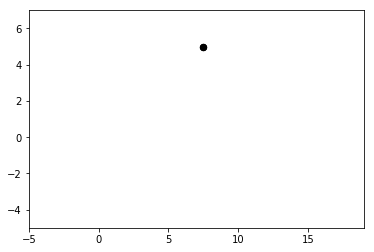

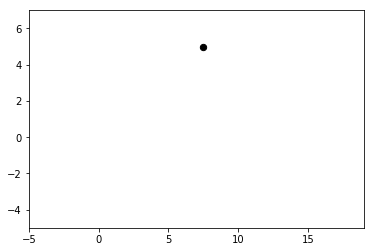

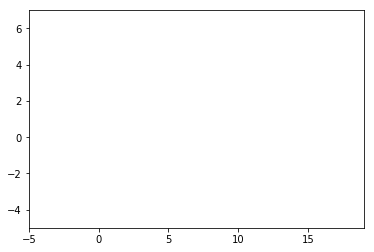

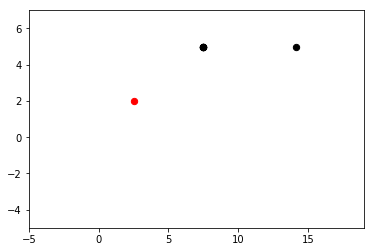

In [95]:
f= 'Data1st.txt' #just importing data from touch in a single point with different forces
# This dataset has the peculiarity that I only touched the same spot ten times, therefore, my estimations should
# be close to those coordinates.
window_size= 1000
sampling_frequency= 400 #Hz
Window1= deque([])
Window2= deque([])
Window3= deque([])
Window4= deque([])
Window5= deque([])
Window6= deque([])
j=0
# Each line is a time stamp. 
# The sampling rate at which this data was taken is 400 Hz and the goal is 1kHz
right1=0
right2=0
right3=0
right4=0
right5=0
right6=0

#im = pyplot.imread('sensors.png')
#implot = pyplot.imshow(im)
pyplot.figure()
with open(f) as file: #this loop will be replaced by some pyserial readline instruction if a life demo were to be done
    for line in file:
        data, timestamp = line.split("-")
        Sensors= data.split(",")
        
        #Because this is a simulation of the "big picture", I am going to use 6 deques:
        Sensors1=Sensors[0]
        Sensors2=Sensors[1]
        Sensors3=Sensors[2]
        Sensors4=Sensors[3]
        Sensors5=Sensors[4]
        Sensors6=Sensors[5]
        
        if j<=window_size:    
            Window1.append(Sensors1)
            Window2.append(Sensors2)
            Window3.append(Sensors3)
            Window4.append(Sensors4)
            Window5.append(Sensors5)
            Window6.append(Sensors6)
            j= j+1
        else:
            Window1.append(Sensors1)
            Window2.append(Sensors2)
            Window3.append(Sensors3)
            Window4.append(Sensors4)
            Window5.append(Sensors5)
            Window6.append(Sensors6)
            Window1.popleft()
            Window2.popleft()
            Window3.popleft()
            Window4.popleft()
            Window5.popleft()
            Window6.popleft()  
            
# Now that the windows are ready, I will send them to the Event function and if most of the sensors agree
# that there is an event, then the breeding pairing will actuate

        if j>= window_size:
            yesno1, right1, sensdata1= Event(Window1, right1)
            sensdata2= Window2[-1]
            sensdata3= Window3[-1]
            sensdata4= Window4[-1]
            sensdata5= Window5[-1]
            sensdata6= Window6[-1]
  
            if yesno1==1:
                listsens= (sensdata1, sensdata2, sensdata3, sensdata4, sensdata5, sensdata6)
                pair1= Breeding(listsens, 0) #sensor1 will start at 0
                x1= Hash[1][0]
                y1= Hash[1][1]
                x2= Hash[pair1[0]+1][0]
                y2= Hash[pair1[0]+1][1]
                x3= Hash[pair1[1]+1][0]
                y3= Hash[pair1[1]+1][1]
                s1= sensdata1
                s2= listsens[pair1[0]]
                s3= listsens[pair1[1]]
                t12= np.max(signal.correlate(np.asarray(listsens[0], dtype=np.float64),np.asarray(listsens[pair1[0]], dtype=np.float64), mode='full'))
                t23= np.max(signal.correlate(np.asarray(listsens[pair1[0]], dtype=np.float64),np.asarray(listsens[pair1[1]], dtype=np.float64), mode='full'))
                t31= np.max(signal.correlate(np.asarray(listsens[pair1[1]], dtype=np.float64),np.asarray(listsens[0], np.float64), mode='full'))
                
                u,i= SourceLoc(float(s1),float(s2),float(s3),[.3,.3],x1,x2,x3,y1,y2,y3,t12,t23,t31,rtol=1e-15,maxit=500,
                               epsilon=1e-4,verbose= False)
                
                # put a red dot, size 40, at 2 locations:
                pyplot.scatter(u[0], u[1], c='k', s=40)
                 
                pyplot.xlim(xmin=-5)
                pyplot.xlim(xmax= 19)
                pyplot.ylim(ymin= -5)
                pyplot.ylim(ymax= 7)
                print(u)  
                
pyplot.scatter(2.5, 2, c='r', s=40)          
pyplot.show()


## What does order of accuracy mean in this context?

The means to solve this problem was the Newton Raphson algorithm. Newton Raphson's essence is to solve a complicated equation by optimizing an expression. However, it is unknown whether the optimization of this expression is actually the solution to the problem or not. 

** Equations in the case of an anisotropic medium or cylindrical coordinates **


In the case of an anisotropic medium, the time delay would not be linear. This means that the shear waves would split. These equation must be then solved in two steps: one step to solve for the nonlinear time delay of the propagating wave and another one to solve for the triangularization. 

In the case of a spherical/cylindrical coordinate system, one can either approximate the solution as if they were a flat plate by sacrificing accuracy or one can also use FEM in order to discretize the grid in a manner that it can be later assembled in a way the solutions are in the corresponding symmetry of the problem. 

** Eikonal Equation **

For anisotropic media, the time delay problem can be also interpreted as a shortest path problem through the Eikonal Equation, which takes the form of:

\begin{equation}
|\nabla u|= \frac{1}{f(x)}
\end{equation}

http://iopscience.iop.org.colorado.idm.oclc.org/article/10.1209/0295-5075/9/6/003/pdf

where $f(x)$ is a function that involves the wave speed.

The weak form for this equation is simple, but the right hand side has to be a term that involves the wave speed in that material. If we make a manufactured solution to that equation and solve it using the FD2D notebook's solution, we are left with two different solutions for when the gradient gives a positive value and when the gradient gives a negative value or we can just use abs() after computing the gradient. Either way makes use of that solution in the notebook.

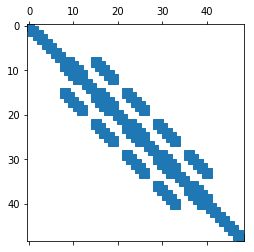

In [14]:
############################
#   BORROWED FROM FD2D     #
############################

def laplacian2dEikonal(h, f, g0):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = np.linspace(-1, 11, m)
    y, x = np.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = 1/f(x, y).flatten()
    A = sp.lil_matrix((m*m, m*m))
    def idx(i, j):
        return i*m + j
    mask = np.zeros_like(x, dtype=int)
    mask[1:-1,1:-1] = 1
    mask = mask.flatten()
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = np.array([idx(*pair) for pair in 
                                    [(i-1, j), (i, j-1),
                                     (i, j),
                                     (i, j+1), (i+1, j)]])
            stencilw = 1/h**2 * np.array([-1, -1, 4, -1, -1])
            if mask[row] == 0: # Dirichlet boundary
                A[row, row] = 1
                rhs[row] = u0[row]
            else:
                smask = mask[stencili]
                cols = stencili[smask == 1]
                A[row, cols] = stencilw[smask == 1]
                bdycols = stencili[smask == 0]
                rhs[row] -= stencilw[smask == 0] @ u0[bdycols]
    return x, y, A.tocsr(), rhs

x, y, A, rhs = laplacian2dEikonal(.15, lambda x,y: 0*x+1, lambda x,y: 0*x)

pyplot.spy(A);
sp.linalg.norm(A - A.T)
pyplot.show()

(51, 51) 33.7162304931


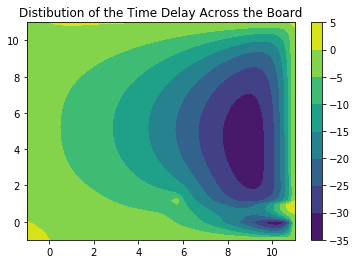

In [16]:
class mms0:
    def u(x, y):
        return x*np.exp(-x)*np.tanh(y)
    def grad_u(x, y):
        return np.array([(1 - x)*np.exp(-x)*np.tanh(y),
                            x*np.exp(-x)*(1 - np.tanh(y)**2)])
    def laplacian_u(x, y):
        return ((2 - x)*np.exp(-x)*np.tanh(y)
                - 2*x*np.exp(-x)*(np.tanh(y)**2 - 1)*np.tanh(y))
    def grad_u_dot_normal(x, y, n):
        return grad_u(x, y) @ n

x, y, A, rhs = laplacian2dEikonal(.02, mms0.laplacian_u, mms0.u)
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
print(u.shape, np.linalg.norm((u - mms0.u(x,y)).flatten(), np.inf))
pyplot.contourf(x, y, u)
pyplot.colorbar()
pyplot.title('Distibution of the Time Delay Across the Board')
#pyplot.figure()
#pyplot.contourf(x, y, u - mms0.u(x, y))
#pyplot.colorbar()
#pyplot.title('Error');
pyplot.show()